# CRNN usando PyTorch Lightning
## Objetivos

- Importar una base de datos de audio
- Definir un modulo Dataset
- Definir un modelo convolucional - recurrente para clasificacion de audio

## Instalar e importar bibliotecas


In [5]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

In [ ]:
!mkdir -p ./data/esc50
!curl -L -o ./data/esc50/esc-50.zip https://www.kaggle.com/api/v1/datasets/download/mmoreaux/environmental-sound-classification-50
!unzip -o ./data/esc50/esc-50.zip -d ./data/esc50

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1457M  100 1457M    0     0  41.6M      0  0:00:34  0:00:34 --:--:-- 46.1M
Archive:  ./data/esc50/esc-50.zip
  inflating: ./esc50-data/audio/audio/1-100032-A-0.wav  
  inflating: ./esc50-data/audio/audio/1-100038-A-14.wav  
  inflating: ./esc50-data/audio/audio/1-100210-A-36.wav  
  inflating: ./esc50-data/audio/audio/1-100210-B-36.wav  
  inflating: ./esc50-data/audio/audio/1-101296-A-19.wav  
  inflating: ./esc50-data/audio/audio/1-101296-B-19.wav  
  inflating: ./esc50-data/audio/audio/1-101336-A-30.wav  
  inflating: ./esc50-data/audio/audio/1-101404-A-34.wav  
  inflating: ./esc50-data/audio/audio/1-103298-A-9.wav  
  inflating: ./esc50-data/audio/audio/1-103995-A-30.wav  
  inflating: ./esc50-data/audio/audio/1-103999-A-30.wav  
  inflating: .

## Definición de hiperparámetros de la red

In [8]:
torch.manual_seed(47)
BATCH_SIZE = 32
NUM_EPOCHS = 40 
LEARNING_RATE = 1e-4
NUM_WORKERS = 4
CLASES = 50

ANNOTATIONS_FILE = './data/esc50/esc50.csv'
AUDIO_DIR = './data/esc50/audio/audio/44100'
SAMPLE_RATE = 16_000
MAX_LEN_SEC = 5

In [9]:
all_csv = pd.read_csv(ANNOTATIONS_FILE)
print(all_csv.head(5))

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


torch.Size([1, 220500]) 44100


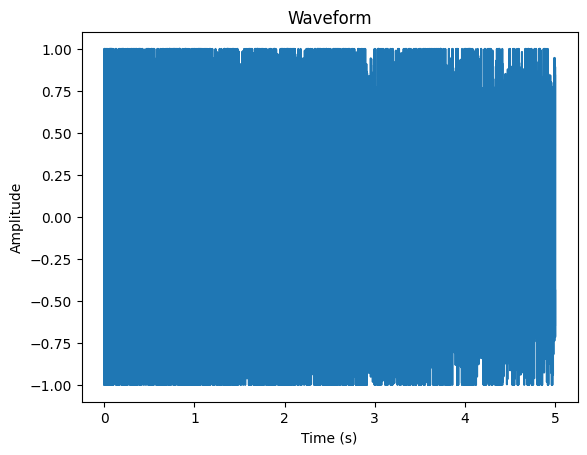

In [10]:
# Load the audio file
path = os.path.join(AUDIO_DIR, all_csv.iloc[15]['filename'])
waveform, sample_rate = torchaudio.load(path)
print(waveform.shape, sample_rate)
# Create a time axis
time_axis = torch.arange(0, waveform.shape[-1]) / sample_rate
# Plot the waveform
plt.plot(time_axis, waveform[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

Ejemplo: ./data/esc50/audio/audio/44100/1-110537-A-22.wav


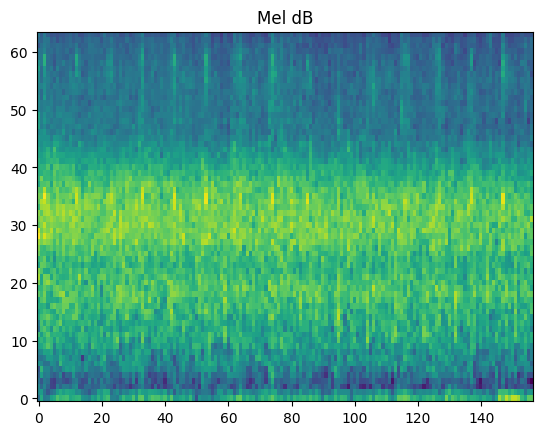

In [11]:
print("Ejemplo:", path)
waveform, native_sr = torchaudio.load(path)
waveform = waveform.mean(0, keepdim=True)  # mono
if native_sr != SAMPLE_RATE:
    waveform = T.Resample(native_sr, SAMPLE_RATE)(waveform)

mel_spec = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
mel = mel_spec(waveform)                    # [1, 64, T]
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)
plt.imshow(mel_db[0], origin='lower', aspect='auto'); plt.title('Mel dB'); plt.show()

### Definicion de clase Dataset para Enviromental

In [12]:
class EnviromentalDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, max_len):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.max_len = max_len

    def _get_audio_sample_path(self, index):
        fname = self.annotations.loc[index, 'filename']
        path = os.path.join(self.audio_dir, fname)
        if not os.path.exists(path):
            raise FileNotFoundError(f"No existe: {path}")
        return path

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            signal = T.Resample(sr, self.target_sample_rate)(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = signal.mean(dim=0, keepdim=True)
        return signal

    def _cut_if_necessary(self, signal):
        max_len = self.max_len * self.target_sample_rate
        if signal.shape[1] > max_len:
            signal = signal[:, :max_len]
        return signal

    def _right_pad_if_necessary(self, signal):
        max_len = self.max_len * self.target_sample_rate
        if signal.shape[1] < max_len:
            pad = max_len - signal.shape[1]
            signal = F.pad(signal, (0, pad))
        return signal

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)
        label = int(self.annotations.loc[index, 'target'])

        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        mel = self.transformation(signal).to(torch.float32)  # [1, 64, T]
        return mel, label

mel_transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
env_dataset = EnviromentalDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, SAMPLE_RATE, MAX_LEN_SEC)
env_dataloader = DataLoader(env_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Tomar un batch para fijar dimensiones
sample_batch, _ = next(iter(env_dataloader))  # [B, 1, 64, T]
_, C, H, W = sample_batch.shape
print(f"Input mel shape: C={C}, H(n_mels)={H}, W(frames)={W}")


Input mel shape: C=1, H(n_mels)=64, W(frames)=157


### Definición de Enviromental DataModule para Lightning

In [13]:
class EnviromentalDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, root_dir, mel_transf, target_sr, max_len_s, batch_size, num_workers):
        super().__init__()
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.mel_transf = mel_transf
        self.target_sr = target_sr
        self.max_len_s = max_len_s
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        full = EnviromentalDataset(self.csv_file, self.root_dir, self.mel_transf, self.target_sr, self.max_len_s)
        n = len(full)
        n_train = int(0.8 * n)
        n_val = (n - n_train) // 2
        n_test = n - n_train - n_val
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(full, [n_train, n_val, n_test])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

data_module = EnviromentalDataModule(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, SAMPLE_RATE, MAX_LEN_SEC, BATCH_SIZE, NUM_WORKERS)


## Definición de la arquitectura de la CRNN

In [8]:
class CRNN(nn.Module):
    def __init__(self, input_dim, num_classes=CLASES):
        """
        input_dim: (C=1, H=64, W=frames)
        Conv + Pool x2 -> H' = H//4, W' = W//4, C' = 32
        LSTM: seq_len = W', input_size = 32 * H'
        """
        super().__init__()
        C, H, W = input_dim
        self.conv1 = nn.Conv2d(C, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        H2 = H // 4
        W2 = W // 4
        self.lstm_input_size = 32 * H2
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=256, num_layers=2,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):               # x: [B, 1, 64, W]
        x = self.pool(self.relu(self.conv1(x)))  # [B,16,H/2,W/2]
        x = self.pool(self.relu(self.conv2(x)))  # [B,32,H/4,W/4]
        # Reorganizar: secuencia = eje temporal (W/4)
        B, C, H2, W2 = x.shape
        x = x.permute(0, 3, 1, 2).contiguous()   # [B, W2, C, H2]
        x = x.view(B, W2, C * H2)                # [B, W2, 32*H2]
        x, _ = self.lstm(x)                      # [B, W2, 512]
        x = x[:, -1, :]                          # último paso temporal
        x = self.fc(x)                           # logits [B, num_classes]
        return x                                 # NO softmax

## Definición del Módulo Lightning

In [ ]:
class Lightning_CRNN(pl.LightningModule):
    def __init__(self, input_dim, num_classes, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = CRNN(input_dim=input_dim, num_classes=num_classes)
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc  = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)                                # logits
        loss = F.cross_entropy(logits, y)               # espera logits
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.valid_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch)
        self.test_acc.update(preds, y)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.valid_acc.reset()

    def on_test_epoch_end(self):
        self.test_acc.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


## Entrenamiento del modelo

In [10]:
input_dim = (C, H, W)
lightning_model = Lightning_CRNN(input_dim=input_dim, num_classes=CLASES, lr=LEARNING_RATE)

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc")
logger = CSVLogger(save_dir="logs/", name="crnn-esc50")
progress = RichProgressBar(leave=True)

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[callback_check, progress],
    accelerator="auto",
    devices="auto",
    logger=logger,
    deterministic=False,
    log_every_n_steps=10
)

start = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)
print(f"Minutos entrenamiento: {(time.time()-start)/60:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA H200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.c

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ CRNN               │  3.2 M │ train │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 2 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 10                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of
metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have 
not yet been updated.
  warnings.warn(*args, **kwargs)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=59` reached.


Minutos entrenamiento: 4.66


## Graficamos las curvas de aprendizaje del modelo

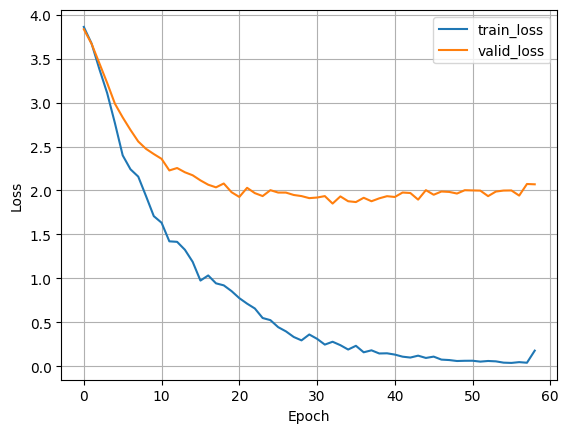

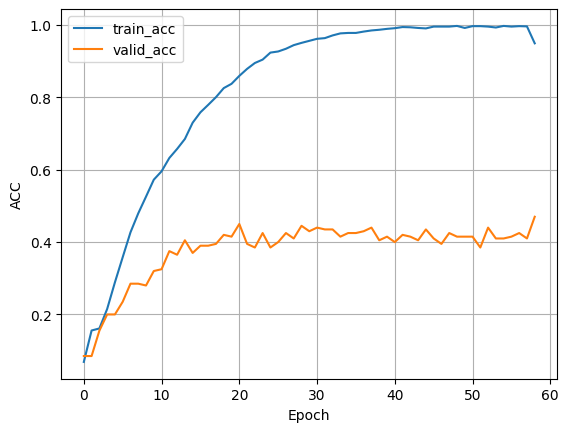

In [11]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [12]:
trainer.test(model = lightning_model, datamodule = data_module, ckpt_path = 'best') # cargamos el mejor checkpoint del modelo

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/crnn-esc50/version_2/checkpoints/epoch=58-step=2950.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/crnn-esc50/version_2/checkpoints/epoch=58-step=2950.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8100000023841858     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8100000023841858}]